# K-Means Clustering with Real World Dataset from scratch

Data Description:

- data.csv contains 10000 data samples, and each sample has 784 features.
- label.csv contains the ground-truth labels of all data samples. There are 10 kinds of labels in the label.csv.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### K-means clustering algorithm from scratch

In [2]:
from collections import Counter

class K_Means():
    
    def __init__(self, k=3, dist="EUC", max_iter=150, centroids=None, verbose=False, tol=0.001):
        self.k = k
        self.max_iter = max_iter
        self.cluster_ids = np.arange(k, dtype="int")
        self.cluster_labels = np.zeros(self.k, dtype="int")
        self.centroids = centroids
        self.sse = 0
        self.verbose = verbose
        self.tol = tol
        
        # select appropriate distance metrics
        if dist in ["EUC", "COS", "JAC", "MAN"]:
            if dist == "EUC":
                self.dist = self._euclidean_distance
            elif dist == "COS":
                self.dist = self._cosine_distance
            elif dist == "MAN":
                self.dist = self._manhattan_distance
            else:
                self.dist = self._jaccard_distance
        else:
            raise ValueError("Invalid value for distance metrics...")
    
    
    def fit(self, X, Y=None):    
        self.X = X
        self.Y = Y
        self.rows, self.columns = X.shape
        np.random.seed(24)
        
        # Step 1: initialization
        # randomly selecting k rows as k centroid points
        # only if initial centeroids are not provided
        if type(self.centroids)==type(None):
            self.centroids = self.X[np.random.choice(self.rows, self.k, replace=False)]
        self.clusters = np.zeros(self.rows, dtype="int")
        
        # calculating initial sse
        sse = 0
        for cluster_id in self.cluster_ids:
            cluster_point_indexes = np.where(self.clusters == cluster_id)
            sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
        self.sse = sse
        
        # Step 3: Stop Criteria
        # 1. when maximum preset value of number of iterations is complete.
        # 2. when centroids do not change      
        # 3. when sse increases in next iteration
        for iteration in range(1, self.max_iter+1):
        #while True:
            # Step 2: Repeat          
            # 1. assign datpoints to k clusters based on the distance between 
            # the centeroids and the points
            # traverse all rows in the dataset
            for row_id in range(self.rows):
                distances = [self.dist(X[row_id], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
                min_dist_cluster_id = distances.index(min(distances))
                if self.clusters[row_id]!=min_dist_cluster_id:
                    self.clusters[row_id] = min_dist_cluster_id
            #print("centriods:", self.centroids)
            
            prev_centroids = np.copy(self.centroids)
            # 2. compute the new centroids points
            # average of all points in the cluster
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                if len(cluster_point_indexes[0])!=0:
                    self.centroids[cluster_id] = np.average(self.X[cluster_point_indexes], axis=0)
                
                # compute cluster labels only if Y(original labels) are given
                if type(self.Y)!=type(None):
                    #print("cluster_point_indexes", cluster_point_indexes)
                    #print(cluster_point_indexes[0])
                    # only if there are actual elements in the cluster
                    if len(cluster_point_indexes[0])!=0:
                        label_counts = Counter(self.Y[cluster_point_indexes])
                        #print(label_counts)
                        self.cluster_labels[cluster_id] = int(label_counts.most_common(1)[0][0])
                    else:
                        self.cluster_labels[cluster_id] = cluster_id
                
                # else assign cluster_ids as labels
                else:
                    self.cluster_labels[cluster_id] = self.cluster_ids[cluster_id]
            #print("centriods:", self.centroids)

            # check for stopping condition
            # 2. when centroids do not change      
            change_in_centroid_postion = False
            for c in range(self.k):
                #print(self.dist(prev_centroids[c], self.centroids[c]))
                if self.dist(prev_centroids[c], self.centroids[c]) > self.tol:
                    change_in_centroid_postion = True
                    
            # check for stopping condition
            # 3. when sse increases in next iteration
            sse = 0
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
                
            if self.verbose and iteration%10==0:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Cluster labels: ", self.cluster_labels)
                #print("Centeriods:", self.centroids)
            
            # 2 and 3 breaking conditions
            if not change_in_centroid_postion:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Breaking.. Centroids do no change..")
                break
                
            if self.sse <= sse:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration+1))
                print("Breaking.. SSE increased..")
                break
                
            self.sse = sse
                        
            
    def predict(self, X_test):
        # create a placeholder to store predictions
        y_preds = np.zeros((X_test.shape[0], 1)) 
        # for every test example
        for index in range(X_test.shape[0]):
            # compute distances from each cluster centriod
            distances = [self.dist(X_test[index], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
            # index of minimum distance cluster as per algorithm
            y_preds[index] = distances.index(min(distances))
            # actual label of the cluster
            y_preds[index] = self.cluster_labels[int(y_preds[index])]            
        return y_preds
    
    
    def _manhattan_distance(self, x, y):
        return np.sum(np.abs(x - y))
    
    
    def _euclidean_distance(self, x, y):
        return np.sum(np.square(x-y))
    
    
    def _cosine_distance(self, x, y):
        return 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    
    
    def _jaccard_distance(self, x, y):
        values = np.array([[x], [y]])
        return 1 - np.sum(values.min(axis=0))/np.sum(values.max(axis=0))

    

**Sample testing**

In [3]:
temp_x = np.array([[1,1], [3, 3], [1, 0], [0, 1], [4, 4]], dtype="float")
temp_y = np.array([1, 2, 1, 1, 2])
test_model = K_Means(k=2, dist="JAC", verbose=True)
test_model.fit(temp_x, temp_y)

SSE 2.33 for iteration 3.. 
Breaking.. Centroids do no change..


In [4]:
y_preds = test_model.predict(temp_x)
y_preds

array([[1.],
       [2.],
       [1.],
       [1.],
       [2.]])

In [5]:
test_model.centroids

array([[3.5       , 3.5       ],
       [0.66666667, 0.66666667]])

# Task 1

**Suppose we have 10 college football teams X1 to X10. We want to cluster them into 2
groups. For each football team, we have two features: One is # wins in Season 2016, and the
other is # wins in Season 2017.**

In [6]:
teams = np.array([[3,5], [3,4], [2,8], [2,3], [6,2], [6,4], [7,3], [7,4], [8,5], [7,6]])

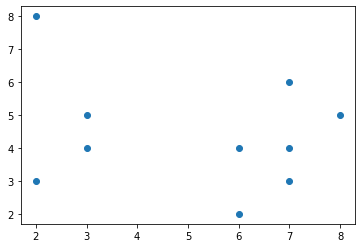

In [7]:
plt.scatter(teams[:, 0], teams[:,1]);

**Q.1) Initialize with two centroids, (4, 6) and (5, 4). Use Manhattan distance as the distance metric. First, perform one iteration of the K-means algorithm and report the coordinates of the
resulting centroids. Second, please use K-Means to find two clusters.**

Centroids after 1 iteration: [4.   6.33],[5.57 3.57],
SSE 54.10 for iteration 1.. 
Breaking.. Centroids do no change..
Centroids after training: [4.   6.33],[5.57 3.57],

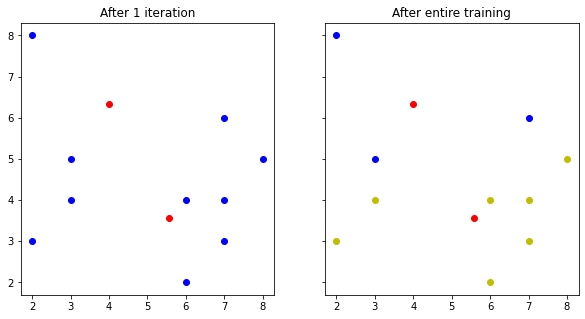

In [8]:
# Part 1
init_centroids = np.array([[4, 6], [5, 4]], dtype="float")
man_model = K_Means(k=2, max_iter=1, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after 1 iteration: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")
print("")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.scatter(teams[:, 0], teams[:,1], color="b");
ax1.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax1.set_title("After 1 iteration");

# part 2
man_model = K_Means(k=2, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after training: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")

# Plotting results
colors = ["b", "y"]
for index, cluster in enumerate(man_model.clusters):
        ax2.scatter(teams[index, 0], teams[index,1], color=colors[int(cluster)%2]);
ax2.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax2.set_title("After entire training");

**Q.2) Initialize with two centroids, (4, 6) and (5, 4). Use Euclidean distance as the distance metric. First, perform one iteration of the K-means algorithm and report the coordinates of the
resulting centroids. Second, please use K-Means to find two clusters.**

Centroids after 1 iteration: [2.5 6.5],[5.75 3.88],
SSE 27.83 for iteration 2.. 
Breaking.. Centroids do no change..
Centroids after training: [2.5 5. ],[6.83 4.  ],

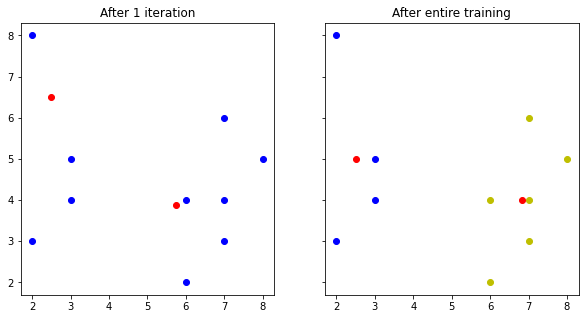

In [9]:
# Part 1
init_centroids = np.array([[4, 6], [5, 4]], dtype="float")
euc_model = K_Means(k=2, max_iter=1, centroids=init_centroids, dist="EUC")
euc_model.fit(teams)
print("Centroids after 1 iteration: ", end="")
for centroid in euc_model.centroids:
    print(np.around(centroid, 2), end=",")
print("")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.scatter(teams[:, 0], teams[:,1], color="b");
ax1.scatter(euc_model.centroids[:,0], euc_model.centroids[:,1], color="r");
ax1.set_title("After 1 iteration");

# part 2
euc_model = K_Means(k=2, centroids=init_centroids, dist="EUC")
euc_model.fit(teams)
print("Centroids after training: ", end="")
for centroid in euc_model.centroids:
    print(np.around(centroid, 2), end=",")

# Plotting results
colors = ["b", "y"]
for index, cluster in enumerate(euc_model.clusters):
        ax2.scatter(teams[index, 0], teams[index,1], color=colors[int(cluster)%2]);
ax2.scatter(euc_model.centroids[:,0], euc_model.centroids[:,1], color="r");
ax2.set_title("After entire training");

**Q.3) Initialize with two centroids, (3, 3) and (8, 3). Use Manhattan distance as the distance metric.First, perform one iteration of the K-means algorithm and report the coordinates of the
resulting centroids. Second, please use K-Means to find two clusters.**

Centroids after 1 iteration: [2.5 5. ],[6.83 4.  ],
SSE 27.83 for iteration 1.. 
Breaking.. Centroids do no change..
Centroids after training: [2.5 5. ],[6.83 4.  ],

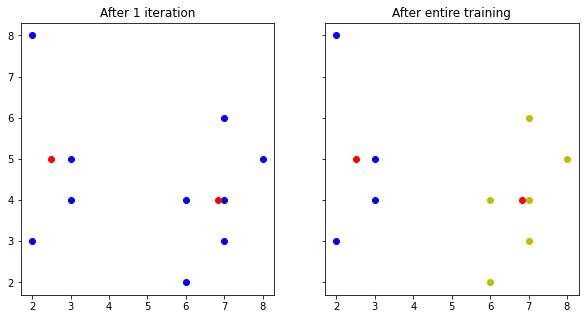

In [10]:
# Part 1
init_centroids = np.array([[3, 3], [8, 3]], dtype="float")
man_model = K_Means(k=2, max_iter=1, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after 1 iteration: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")
print("")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.scatter(teams[:, 0], teams[:,1], color="b");
ax1.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax1.set_title("After 1 iteration");

# part 2
man_model = K_Means(k=2, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after training: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")

# Plotting results
colors = ["b", "y"]
for index, cluster in enumerate(man_model.clusters):
        ax2.scatter(teams[index, 0], teams[index,1], color=colors[int(cluster)%2]);
ax2.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax2.set_title("After entire training");

**Q.4) Initialize with two centroids, (3, 2) and (4, 8). Use Manhattan distance as the distance metric.First, perform one iteration of the K-means algorithm and report the coordinates of the
resulting centroids. Second, please use K-Means to find two clusters.**

Centroids after 1 iteration: [4.86 3.57],[5.67 6.33],
SSE 57.90 for iteration 1.. 
Breaking.. Centroids do no change..
Centroids after training: [4.86 3.57],[5.67 6.33],

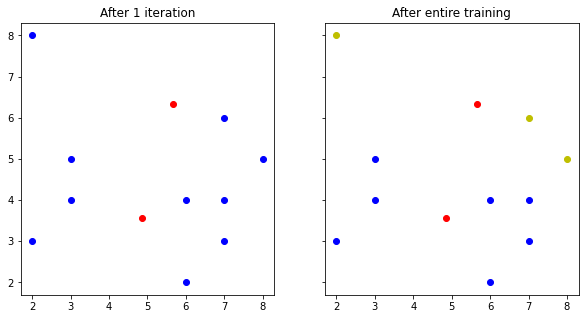

In [11]:
# Part 1
init_centroids = np.array([[3, 2], [4, 8]], dtype=float)
man_model = K_Means(k=2, max_iter=1, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after 1 iteration: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")
print("")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.scatter(teams[:, 0], teams[:,1], color="b");
ax1.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax1.set_title("After 1 iteration");

# part 2
man_model = K_Means(k=2, centroids=init_centroids, dist="MAN")
man_model.fit(teams)
print("Centroids after training: ", end="")
for centroid in man_model.centroids:
    print(np.around(centroid, 2), end=",")

# Plotting results
colors = ["b", "y"]
for index, cluster in enumerate(man_model.clusters):
        ax2.scatter(teams[index, 0], teams[index,1], color=colors[int(cluster)%2]);
ax2.scatter(man_model.centroids[:,0], man_model.centroids[:,1], color="r");
ax2.set_title("After entire training");

# Task 2: K-Means Clustering with Real World Dataset
**First, download a simulated dataset: hw4_kmeans_data.zip from Modules->Datsets. Then,
implement the K-means algorithm from scratch. K-means algorithm computes the distance of a
given data point pair. Replace the distance computation function with Euclidean distance, 1-
Cosine similarity, and 1 – the Generalized Jarcard similarity (refer to:
https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/jaccard.htm).**

In [12]:
# import dataset
X = pd.read_csv("hw4_kmeans_data/data.csv", header=None)
Y = pd.read_csv("hw4_kmeans_data/label.csv", header=None)

In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
Y.head()

,0
0,7
1,2
2,1
3,0
4,4


In [15]:
k_labels = len(Y[0].value_counts())
print(k_labels)

10


In [16]:
X = X.to_numpy(dtype="float")
Y = Y.to_numpy(dtype="float").flatten()

**Q1: Run K-means clustering with Euclidean, Cosine and Jarcard similarity. Specify K= the
number of categorical values of y (the number of classifications). Compare the SSEs of
Euclidean-K-means, Cosine-K-means, Jarcard-K-means. Which method is better?**

In [17]:
euc_model = K_Means(k=k_labels, dist="EUC", verbose=True)
euc_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = euc_model.predict(X)
print("Accuracy using Euclidean-K-means: ", accuracy_score(Y, y_preds))

SSE 25787845756.54 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 6 3 9 1 6]
SSE 25340298141.49 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25324820133.66 for iteration 30.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 38.. 
Breaking.. Centroids do no change..
Accuracy using Euclidean-K-means:  0.6018


In [18]:
cos_model = K_Means(k=k_labels, dist="COS", verbose=True)
cos_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = cos_model.predict(X)
print("Accuracy using Cosine-K-means: ", accuracy_score(Y, y_preds))

SSE 25881303781.29 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 0 3 9 1 6]
SSE 25733948794.69 for iteration 12.. 
Breaking.. Centroids do no change..
Accuracy using Cosine-K-means:  0.6256


In [19]:
jac_model = K_Means(k=k_labels, dist="JAC", verbose=True)
jac_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = jac_model.predict(X)
print("Accuracy using Jarcard-K-means: ", accuracy_score(Y, y_preds))

SSE 25571284601.52 for iteration 10.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25494050722.57 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25491483767.34 for iteration 24.. 
Breaking.. SSE increased..
Accuracy using Jarcard-K-means:  0.6053


## Comparing different stopping conditions

**1. No change in centroid position.**

In [20]:
from collections import Counter

class K_Means():
    
    def __init__(self, k=3, dist="EUC", max_iter=150, centroids=None, verbose=False, tol=0.001):
        self.k = k
        self.max_iter = max_iter
        self.cluster_ids = np.arange(k, dtype="int")
        self.cluster_labels = np.zeros(self.k, dtype="int")
        self.centroids = centroids
        self.sse = 0
        self.verbose = verbose
        self.tol = tol
        
        # select appropriate distance metrics
        if dist in ["EUC", "COS", "JAC", "MAN"]:
            if dist == "EUC":
                self.dist = self._euclidean_distance
            elif dist == "COS":
                self.dist = self._cosine_distance
            elif dist == "MAN":
                self.dist = self._manhattan_distance
            else:
                self.dist = self._jaccard_distance
        else:
            raise ValueError("Invalid value for distance metrics...")
    
    
    def fit(self, X, Y=None):    
        self.X = X
        self.Y = Y
        self.rows, self.columns = X.shape
        np.random.seed(24)
        
        # Step 1: initialization
        # randomly selecting k rows as k centroid points
        # only if initial centeroids are not provided
        if type(self.centroids)==type(None):
            self.centroids = self.X[np.random.choice(self.rows, self.k, replace=False)]
        self.clusters = np.zeros(self.rows, dtype="int")
        
        # calculating initial sse
        sse = 0
        for cluster_id in self.cluster_ids:
            cluster_point_indexes = np.where(self.clusters == cluster_id)
            sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
        self.sse = sse
        
        # Step 3: Stop Criteria
        # 1. when maximum preset value of number of iterations is complete.
        # 2. when centroids do not change      
        # 3. when sse increases in next iteration
        #for iteration in range(1, self.max_iter+1):
        iteration = 0
        while True:
            # Step 2: Repeat          
            # 1. assign datpoints to k clusters based on the distance between 
            # the centeroids and the points
            # traverse all rows in the dataset
            for row_id in range(self.rows):
                distances = [self.dist(X[row_id], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
                min_dist_cluster_id = distances.index(min(distances))
                if self.clusters[row_id]!=min_dist_cluster_id:
                    self.clusters[row_id] = min_dist_cluster_id
            #print("centriods:", self.centroids)
            
            prev_centroids = np.copy(self.centroids)
            # 2. compute the new centroids points
            # average of all points in the cluster
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                if len(cluster_point_indexes[0])!=0:
                    self.centroids[cluster_id] = np.average(self.X[cluster_point_indexes], axis=0)
                
                # compute cluster labels only if Y(original labels) are given
                if type(self.Y)!=type(None):
                    #print("cluster_point_indexes", cluster_point_indexes)
                    #print(cluster_point_indexes[0])
                    # only if there are actual elements in the cluster
                    if len(cluster_point_indexes[0])!=0:
                        label_counts = Counter(self.Y[cluster_point_indexes])
                        #print(label_counts)
                        self.cluster_labels[cluster_id] = int(label_counts.most_common(1)[0][0])
                    else:
                        self.cluster_labels[cluster_id] = cluster_id
                
                # else assign cluster_ids as labels
                else:
                    self.cluster_labels[cluster_id] = self.cluster_ids[cluster_id]
            #print("centriods:", self.centroids)

            # check for stopping condition
            # 2. when centroids do not change      
            change_in_centroid_postion = False
            for c in range(self.k):
                #print(self.dist(prev_centroids[c], self.centroids[c]))
                if self.dist(prev_centroids[c], self.centroids[c]) > self.tol:
                    change_in_centroid_postion = True
                    
            # check for stopping condition
            # 3. when sse increases in next iteration
            sse = 0
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
                
            if self.verbose and iteration%10==0:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Cluster labels: ", self.cluster_labels)
                #print("Centeriods:", self.centroids)
            
            # 2 and 3 breaking conditions
            if not change_in_centroid_postion:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Breaking.. Centroids do no change..")
                break
                
#             if self.sse <= sse:
#                 print("SSE {:.2f} for iteration {}.. ".format(sse, iteration+1))
#                 print("Breaking.. SSE increased..")
#                 break
                
            self.sse = sse
            iteration += 1
                        
            
    def predict(self, X_test):
        # create a placeholder to store predictions
        y_preds = np.zeros((X_test.shape[0], 1)) 
        # for every test example
        for index in range(X_test.shape[0]):
            # compute distances from each cluster centriod
            distances = [self.dist(X_test[index], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
            # index of minimum distance cluster as per algorithm
            y_preds[index] = distances.index(min(distances))
            # actual label of the cluster
            y_preds[index] = self.cluster_labels[int(y_preds[index])]            
        return y_preds
    
    
    def _manhattan_distance(self, x, y):
        return np.sum(np.abs(x - y))
    
    
    def _euclidean_distance(self, x, y):
        return np.sum(np.square(x-y))
    
    
    def _cosine_distance(self, x, y):
        return 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    
    
    def _jaccard_distance(self, x, y):
        values = np.array([[x], [y]])
        return 1 - np.sum(values.min(axis=0))/np.sum(values.max(axis=0))
          

In [21]:
euc_model = K_Means(k=k_labels, dist="EUC", verbose=True)
euc_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = euc_model.predict(X)
print("Accuracy using Euclidean-K-means: ", accuracy_score(Y, y_preds))

SSE 28113342462.79 for iteration 0.. 
Cluster labels:  [3 9 0 2 7 0 3 4 1 6]
SSE 25739145569.24 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 6 3 9 1 6]
SSE 25336469480.16 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25324534025.24 for iteration 30.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 37.. 
Breaking.. Centroids do no change..
Accuracy using Euclidean-K-means:  0.6018


In [22]:
cos_model = K_Means(k=k_labels, dist="COS", verbose=True)
cos_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = cos_model.predict(X)
print("Accuracy using Cosine-K-means: ", accuracy_score(Y, y_preds))

SSE 28390838327.24 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25782791814.50 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25733948794.69 for iteration 11.. 
Breaking.. Centroids do no change..
Accuracy using Cosine-K-means:  0.6256


In [23]:
jac_model = K_Means(k=k_labels, dist="JAC", verbose=True)
jac_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = jac_model.predict(X)
print("Accuracy using Jarcard-K-means: ", accuracy_score(Y, y_preds))

SSE 28383889095.75 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25549755909.41 for iteration 10.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25492983956.44 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490704218.61 for iteration 30.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490660405.52 for iteration 35.. 
Breaking.. Centroids do no change..
Accuracy using Jarcard-K-means:  0.607


**2. SSE value increases in next iteration**

In [24]:
from collections import Counter

class K_Means():
    
    def __init__(self, k=3, dist="EUC", max_iter=150, centroids=None, verbose=False, tol=0.001):
        self.k = k
        self.max_iter = max_iter
        self.cluster_ids = np.arange(k, dtype="int")
        self.cluster_labels = np.zeros(self.k, dtype="int")
        self.centroids = centroids
        self.sse = 0
        self.verbose = verbose
        self.tol = tol
        
        # select appropriate distance metrics
        if dist in ["EUC", "COS", "JAC", "MAN"]:
            if dist == "EUC":
                self.dist = self._euclidean_distance
            elif dist == "COS":
                self.dist = self._cosine_distance
            elif dist == "MAN":
                self.dist = self._manhattan_distance
            else:
                self.dist = self._jaccard_distance
        else:
            raise ValueError("Invalid value for distance metrics...")
    
    
    def fit(self, X, Y=None):    
        self.X = X
        self.Y = Y
        self.rows, self.columns = X.shape
        np.random.seed(24)
        
        # Step 1: initialization
        # randomly selecting k rows as k centroid points
        # only if initial centeroids are not provided
        if type(self.centroids)==type(None):
            self.centroids = self.X[np.random.choice(self.rows, self.k, replace=False)]
        self.clusters = np.zeros(self.rows, dtype="int")
        
        # calculating initial sse
        sse = 0
        for cluster_id in self.cluster_ids:
            cluster_point_indexes = np.where(self.clusters == cluster_id)
            sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
        self.sse = sse
        
        # Step 3: Stop Criteria
        # 1. when maximum preset value of number of iterations is complete.
        # 2. when centroids do not change      
        # 3. when sse increases in next iteration
        #for iteration in range(1, self.max_iter+1):
        iteration = 0
        while True:
            # Step 2: Repeat          
            # 1. assign datpoints to k clusters based on the distance between 
            # the centeroids and the points
            # traverse all rows in the dataset
            for row_id in range(self.rows):
                distances = [self.dist(X[row_id], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
                min_dist_cluster_id = distances.index(min(distances))
                if self.clusters[row_id]!=min_dist_cluster_id:
                    self.clusters[row_id] = min_dist_cluster_id
            #print("centriods:", self.centroids)
            
            prev_centroids = np.copy(self.centroids)
            # 2. compute the new centroids points
            # average of all points in the cluster
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                if len(cluster_point_indexes[0])!=0:
                    self.centroids[cluster_id] = np.average(self.X[cluster_point_indexes], axis=0)
                
                # compute cluster labels only if Y(original labels) are given
                if type(self.Y)!=type(None):
                    #print("cluster_point_indexes", cluster_point_indexes)
                    #print(cluster_point_indexes[0])
                    # only if there are actual elements in the cluster
                    if len(cluster_point_indexes[0])!=0:
                        label_counts = Counter(self.Y[cluster_point_indexes])
                        #print(label_counts)
                        self.cluster_labels[cluster_id] = int(label_counts.most_common(1)[0][0])
                    else:
                        self.cluster_labels[cluster_id] = cluster_id
                
                # else assign cluster_ids as labels
                else:
                    self.cluster_labels[cluster_id] = self.cluster_ids[cluster_id]
            #print("centriods:", self.centroids)

            # check for stopping condition
            # 2. when centroids do not change      
            change_in_centroid_postion = False
            for c in range(self.k):
                #print(self.dist(prev_centroids[c], self.centroids[c]))
                if self.dist(prev_centroids[c], self.centroids[c]) > self.tol:
                    change_in_centroid_postion = True
                    
            # check for stopping condition
            # 3. when sse increases in next iteration
            sse = 0
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
                
            if self.verbose and iteration%10==0:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Cluster labels: ", self.cluster_labels)
                #print("Centeriods:", self.centroids)
            
            # 2 and 3 breaking conditions
#             if not change_in_centroid_postion:
#                 print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
#                 print("Breaking.. Centroids do no change..")
#                 break
                
            if self.sse <= sse:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration+1))
                print("Breaking.. SSE increased..")
                break
                
            self.sse = sse
            iteration += 1
                        
            
    def predict(self, X_test):
        # create a placeholder to store predictions
        y_preds = np.zeros((X_test.shape[0], 1)) 
        # for every test example
        for index in range(X_test.shape[0]):
            # compute distances from each cluster centriod
            distances = [self.dist(X_test[index], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
            # index of minimum distance cluster as per algorithm
            y_preds[index] = distances.index(min(distances))
            # actual label of the cluster
            y_preds[index] = self.cluster_labels[int(y_preds[index])]            
        return y_preds
    
    
    def _manhattan_distance(self, x, y):
        return np.sum(np.abs(x - y))
    
    
    def _euclidean_distance(self, x, y):
        return np.sum(np.square(x-y))
    
    
    def _cosine_distance(self, x, y):
        return 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    
    
    def _jaccard_distance(self, x, y):
        values = np.array([[x], [y]])
        return 1 - np.sum(values.min(axis=0))/np.sum(values.max(axis=0))     
    

In [25]:
euc_model = K_Means(k=k_labels, dist="EUC", verbose=True)
euc_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = euc_model.predict(X)
print("Accuracy using Euclidean-K-means: ", accuracy_score(Y, y_preds))

SSE 28113342462.79 for iteration 0.. 
Cluster labels:  [3 9 0 2 7 0 3 4 1 6]
SSE 25739145569.24 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 6 3 9 1 6]
SSE 25336469480.16 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25324534025.24 for iteration 30.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 38.. 
Breaking.. SSE increased..
Accuracy using Euclidean-K-means:  0.6018


In [26]:
cos_model = K_Means(k=k_labels, dist="COS", verbose=True)
cos_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = cos_model.predict(X)
print("Accuracy using Cosine-K-means: ", accuracy_score(Y, y_preds))

SSE 28390838327.24 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25782791814.50 for iteration 10.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25593683225.11 for iteration 20.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25571023833.66 for iteration 30.. 
Breaking.. SSE increased..
Accuracy using Cosine-K-means:  0.6117


In [27]:
jac_model = K_Means(k=k_labels, dist="JAC", verbose=True)
jac_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = jac_model.predict(X)
print("Accuracy using Jarcard-K-means: ", accuracy_score(Y, y_preds))

SSE 28383889095.75 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25549755909.41 for iteration 10.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25492983956.44 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25491483767.34 for iteration 23.. 
Breaking.. SSE increased..
Accuracy using Jarcard-K-means:  0.6053


**3. Maximum preset value of 100 iterations is complete**

In [28]:
from collections import Counter

class K_Means():
    
    def __init__(self, k=3, dist="EUC", max_iter=150, centroids=None, verbose=False, tol=0.001):
        self.k = k
        self.max_iter = max_iter
        self.cluster_ids = np.arange(k, dtype="int")
        self.cluster_labels = np.zeros(self.k, dtype="int")
        self.centroids = centroids
        self.sse = 0
        self.verbose = verbose
        self.tol = tol
        
        # select appropriate distance metrics
        if dist in ["EUC", "COS", "JAC", "MAN"]:
            if dist == "EUC":
                self.dist = self._euclidean_distance
            elif dist == "COS":
                self.dist = self._cosine_distance
            elif dist == "MAN":
                self.dist = self._manhattan_distance
            else:
                self.dist = self._jaccard_distance
        else:
            raise ValueError("Invalid value for distance metrics...")
    
    
    def fit(self, X, Y=None):    
        self.X = X
        self.Y = Y
        self.rows, self.columns = X.shape
        np.random.seed(24)
        
        # Step 1: initialization
        # randomly selecting k rows as k centroid points
        # only if initial centeroids are not provided
        if type(self.centroids)==type(None):
            self.centroids = self.X[np.random.choice(self.rows, self.k, replace=False)]
        self.clusters = np.zeros(self.rows, dtype="int")
        
        # calculating initial sse
        sse = 0
        for cluster_id in self.cluster_ids:
            cluster_point_indexes = np.where(self.clusters == cluster_id)
            sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
        self.sse = sse
        
        # Step 3: Stop Criteria
        # 1. when maximum preset value of number of iterations is complete.
        # 2. when centroids do not change      
        # 3. when sse increases in next iteration
        for iteration in range(0, self.max_iter+1):
            # Step 2: Repeat          
            # 1. assign datpoints to k clusters based on the distance between 
            # the centeroids and the points
            # traverse all rows in the dataset
            for row_id in range(self.rows):
                distances = [self.dist(X[row_id], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
                min_dist_cluster_id = distances.index(min(distances))
                if self.clusters[row_id]!=min_dist_cluster_id:
                    self.clusters[row_id] = min_dist_cluster_id
            #print("centriods:", self.centroids)
            
            prev_centroids = np.copy(self.centroids)
            # 2. compute the new centroids points
            # average of all points in the cluster
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                if len(cluster_point_indexes[0])!=0:
                    self.centroids[cluster_id] = np.average(self.X[cluster_point_indexes], axis=0)
                
                # compute cluster labels only if Y(original labels) are given
                if type(self.Y)!=type(None):
                    #print("cluster_point_indexes", cluster_point_indexes)
                    #print(cluster_point_indexes[0])
                    # only if there are actual elements in the cluster
                    if len(cluster_point_indexes[0])!=0:
                        label_counts = Counter(self.Y[cluster_point_indexes])
                        #print(label_counts)
                        self.cluster_labels[cluster_id] = int(label_counts.most_common(1)[0][0])
                    else:
                        self.cluster_labels[cluster_id] = cluster_id
                
                # else assign cluster_ids as labels
                else:
                    self.cluster_labels[cluster_id] = self.cluster_ids[cluster_id]
            #print("centriods:", self.centroids)

            # check for stopping condition
            # 2. when centroids do not change      
            change_in_centroid_postion = False
            for c in range(self.k):
                #print(self.dist(prev_centroids[c], self.centroids[c]))
                if self.dist(prev_centroids[c], self.centroids[c]) > self.tol:
                    change_in_centroid_postion = True
                    
            # check for stopping condition
            # 3. when sse increases in next iteration
            sse = 0
            for cluster_id in self.cluster_ids:
                cluster_point_indexes = np.where(self.clusters == cluster_id)
                sse += np.sum((self.X[cluster_point_indexes] - self.centroids[cluster_id])**2)
                
            if self.verbose and iteration%20==0:
                print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
                print("Cluster labels: ", self.cluster_labels)
                #print("Centeriods:", self.centroids)
            
            # 2 and 3 breaking conditions
#             if not change_in_centroid_postion:
#                 print("SSE {:.2f} for iteration {}.. ".format(sse, iteration))
#                 print("Breaking.. Centroids do no change..")
#                 break
                
#             if self.sse <= sse:
#                 print("SSE {:.2f} for iteration {}.. ".format(sse, iteration+1))
#                 print("Breaking.. SSE increased..")
#                 break
                
            self.sse = sse
            iteration += 1
                        
            
    def predict(self, X_test):
        # create a placeholder to store predictions
        y_preds = np.zeros((X_test.shape[0], 1)) 
        # for every test example
        for index in range(X_test.shape[0]):
            # compute distances from each cluster centriod
            distances = [self.dist(X_test[index], self.centroids[cluster_id]) for cluster_id in self.cluster_ids]
            # index of minimum distance cluster as per algorithm
            y_preds[index] = distances.index(min(distances))
            # actual label of the cluster
            y_preds[index] = self.cluster_labels[int(y_preds[index])]            
        return y_preds
    
    
    def _manhattan_distance(self, x, y):
        return np.sum(np.abs(x - y))
    
    
    def _euclidean_distance(self, x, y):
        return np.sum(np.square(x-y))
    
    
    def _cosine_distance(self, x, y):
        return 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    
    
    def _jaccard_distance(self, x, y):
        values = np.array([[x], [y]])
        return 1 - np.sum(values.min(axis=0))/np.sum(values.max(axis=0))
  

In [29]:
euc_model = K_Means(k=k_labels, max_iter=100, dist="EUC", verbose=True)
euc_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = euc_model.predict(X)
print("Accuracy using Euclidean-K-means: ", accuracy_score(Y, y_preds))

SSE 28113342462.79 for iteration 0.. 
Cluster labels:  [3 9 0 2 7 0 3 4 1 6]
SSE 25336469480.16 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 40.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 60.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 80.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25323592000.27 for iteration 100.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
Accuracy using Euclidean-K-means:  0.6018


In [30]:
cos_model = K_Means(k=k_labels, max_iter=100, dist="COS", verbose=True)
cos_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = cos_model.predict(X)
print("Accuracy using Cosine-K-means: ", accuracy_score(Y, y_preds))

SSE 28390838327.24 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25593683225.11 for iteration 20.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25570659997.08 for iteration 40.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25570345300.49 for iteration 60.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25570345300.49 for iteration 80.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
SSE 25570345300.49 for iteration 100.. 
Cluster labels:  [8 4 0 2 7 5 3 9 1 6]
Accuracy using Cosine-K-means:  0.6104


In [31]:
jac_model = K_Means(k=k_labels, max_iter=100, dist="JAC", verbose=True)
jac_model.fit(X, Y)

from sklearn.metrics import accuracy_score
y_preds = jac_model.predict(X)
print("Accuracy using Jarcard-K-means: ", accuracy_score(Y, y_preds))

SSE 28383889095.75 for iteration 0.. 
Cluster labels:  [5 4 0 2 7 0 3 9 1 6]
SSE 25492983956.44 for iteration 20.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490712953.25 for iteration 40.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490712953.25 for iteration 60.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490712953.25 for iteration 80.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
SSE 25490712953.25 for iteration 100.. 
Cluster labels:  [8 4 0 2 1 5 3 7 1 6]
Accuracy using Jarcard-K-means:  0.607
